In [ ]:
# Imports
import pandas as pd
import numpy as np
import gzip
import time
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

# Sklearn libraries.
from sklearn import datasets, linear_model, ensemble, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.corpus import stopwords
import string

from collections import Counter
#deep learning library

import json, os, re, shutil, sys, time
import collections, itertools
import unittest
from IPython.display import display, HTML

# NLTK for NLP utils and corpora
import nltk

# NumPy and TensorFlow
import numpy as np
import tensorflow as tf
assert(tf.__version__.startswith("1."))

# utils.pretty_print_matrix uses Pandas. Configure float format here.
import pandas as pd
pd.set_option('float_format', lambda f: "{0:.04f}".format(f))

# Helper libraries
from shared_lib import utils, vocabulary, tf_embed_viz




### 1. Load Data

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [3]:
# Unzip gz file.
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

# Load JSON into dataframe.
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')


In [4]:
start = time.time()
df = getDF('reviews_Clothing_Shoes_and_Jewelry_5.json.gz')
end = time.time()
print "Time Used %fs" %(end - start)

Time Used 42.613845s


### 2. Data Exploration

In [5]:
print df.columns

print df['reviewText'][0]

df.head(5)


Index([u'reviewerID', u'asin', u'reviewerName', u'helpful', u'unixReviewTime',
       u'reviewText', u'overall', u'reviewTime', u'summary'],
      dtype='object')
This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++


,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",1297468800,This is a great tutu and at a really great pri...,5.0000,"02 12, 2011",Great tutu- not cheaply made
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",1358553600,I bought this for my 4 yr old daughter for dan...,5.0000,"01 19, 2013",Very Cute!!
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",1357257600,What can I say... my daughters have it in oran...,5.0000,"01 4, 2013",I have buy more than one
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]",1398556800,"We bought several tutus at once, and they are ...",5.0000,"04 27, 2014","Adorable, Sturdy"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",1394841600,Thank you Halo Heaven great product for Little...,5.0000,"03 15, 2014",Grammy's Angels Love it


#### Exploring helpfulness scores.

In [5]:
helpfulness = []
total_votes = []
for i in df['helpful']:
    if i[1] == 0:
        helpfulness.append(np.nan)
        total_votes.append(np.nan)
    else:
        helpfulness.append(float(i[0])/i[1])
        total_votes.append(i[1])
        
# Convert to numpy array.
helpfulness = np.array(helpfulness)
total_votes = np.array(total_votes)

In [6]:
# Plot boxplot.
nonnan_helpfulness = helpfulness[~np.isnan(helpfulness)]


#### Exploring review text lengths.

In [7]:
# Remove invalid and nan values.
helpfulness_clean = np.delete(helpfulness, 30730)

nonnan_helpfulness_clean = helpfulness_clean[~np.isnan(helpfulness_clean)]



#### Exploring review scores.

### 3. Build Baseline Model

In [8]:
#extract the review text
doc = np.array(df['reviewText'])

# Filter down to reviews with helpfulness scores.
# Remove item with invalid helpfulness score.
doc_clean = np.delete(doc, 30730)
nonnan_doc_clean = doc_clean[~np.isnan(helpfulness_clean)]
y = np.reshape(nonnan_helpfulness_clean,(-1,1))

In [9]:
y_norm = np.rint(y)

### 4. Deep Learning Exploration

#### Build LSTM Model

#### 1.Split the dataset into traing and test 

In [10]:
len(nonnan_doc_clean )
msk = np.random.rand(nonnan_doc_clean.shape[0]) <= 0.7

X_train = nonnan_doc_clean[msk]
X_test = nonnan_doc_clean[~msk]
y_train = y_norm[msk]
y_test = y_norm[~msk]
X_sample = nonnan_doc_clean[0:60000]
y_sample = y_norm[0:60000]

In [12]:
X_train[0]

"The minute I saw this my heart skipped a beat. What a nice case to sort my collection. I love all the compartments and the layout too. You will love this color too. If this is a gift do not hesitate. It will please even the most fussy, as I am. The price is fair if you check around as I did. Seems well made too. It is suitable for an adult though. Not meant as a toy. This is for serious jewelry lover's. Buy it....."

In [21]:
y_train[0]

array([ 1.])

In [11]:
print (len(X_train))
print (len(X_test))
print (len(y_test))

61032
25988
25988


#### 2.Convert the review from list of words to list of word dictionary index

In [16]:
def get_tokens(docs):
    tokens =[]
    for i in docs:
        lowers = i.lower()
        #remove the punctuation using the character deletion step of translate
        no_punctuation = lowers.translate(None, string.punctuation)
        token = nltk.word_tokenize(no_punctuation)
        tokens.extend(token)
    return tokens

tokens = get_tokens(X_sample)

In [57]:
# Vocab size.
V = 10000
def build_dataset(words):
    # Leave the last index for all other words.
    count = collections.Counter(words).most_common(V-1)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, reverse_dictionary

In [58]:
dic, rev_dict = build_dataset(tokens)

In [59]:
len(dic)

9999

In [71]:
max(dic.values())

9998

In [17]:
dic['full']

440

In [51]:
rev_dict[1461]

'c'

In [72]:
#build sample data
X_sample_ids = []
for i in X_sample:
    lowers = i.lower()
    #remove the punctuation using the character deletion step of translate
    no_punctuation = lowers.translate(None, string.punctuation)
    token = nltk.word_tokenize(no_punctuation)
    j = []
    for w in token:
        if w in dic:
            j.append(dic[w])
        # Set token_id to vocab size - 1 if word not in top words
        # since this is zero indexed.
        else:
            j.append(V-1)
    X_sample_ids.append(j)
    
    

In [86]:
#build test data, note if word not in the dictionary, ignore
X_test_ids = []
for i in X_test:
    lowers = i.lower()
    #remove the punctuation using the character deletion step of translate
    no_punctuation = lowers.translate(None, string.punctuation)
    token = nltk.word_tokenize(no_punctuation)
    j = []
    for w in token:
        if w in dic:
            j.append(dic[w])
        # Set token_id to vocab size - 1 if word not in top words
        # since this is zero indexed.
        else:
            j.append(V-1)
    X_test_ids.append(j)


In [87]:
print (X_sample[0])
print (X_sample_ids[0])
print (y_sample[0])

print (X_test[0])
print (X_test_ids[0])
print (y_test[0])




For what I paid for two tutus is unbeatable anywhere!  I ordered a pink and turquios and they are vibrant and beautiful! The tutu is very full! Princess style! Not cheaply made! Not cheap materia! Obviously someone made these with love and care! I paid less than 7 bucks for a tutu I and I feel proud of my self for researching to the point of finding gold!Recommend 2-6 years!My daughter is two ! Wears size 4t and this skirt ( one size ) fit perfect and will probaly be able to accommodate her quickly growing waist for some time!
[8, 86, 1, 611, 8, 134, 9999, 6, 5996, 1122, 1, 84, 3, 567, 2, 9999, 2, 12, 13, 1811, 2, 255, 0, 6132, 6, 26, 440, 3268, 194, 19, 1510, 90, 19, 259, 9999, 1183, 479, 90, 17, 20, 55, 2, 623, 1, 611, 326, 52, 415, 1225, 8, 3, 6132, 1, 2, 1, 115, 3151, 7, 11, 1969, 8, 5697, 4, 0, 580, 7, 813, 9999, 3345, 9999, 414, 6, 134, 460, 29, 6679, 2, 10, 615, 37, 29, 32, 96, 2, 42, 9999, 28, 338, 4, 1768, 206, 473, 2884, 225, 8, 87, 76]
[ 1.]
For what I paid for two tutus is 

#### 3.Pad the sentence with differnt length

In [88]:
#combine the list of words index and label into a dataframe
train_df = pd.DataFrame(np.column_stack([X_sample_ids,y_sample]), 
                               columns=['list_words', 'label'])

In [32]:
train_df.head()

,list_words,label
0,"[8, 86, 1, 611, 8, 134, 10001, 6, 5996, 1122, ...",1.0000
1,"[440, 2, 46, 2232, 10, 6132, 6, 3, 255, 823, 9...",1.0000
2,"[3012, 1044, 2, 5, 6, 373, 25, 1038, 0, 80, 48...",0.0000
3,"[0, 1120, 1, 561, 10, 11, 1696, 9011, 3, 945, ...",1.0000
4,"[55, 10, 494, 270, 22, 46, 141, 661, 610, 1000...",0.0000


In [89]:
#combine the list of words index and label into a dataframe
test_df = pd.DataFrame(np.column_stack([X_test_ids,y_test]), 
                               columns=['list_words', 'label'])

In [34]:
test_df.head()

,list_words,label
0,"[8, 86, 1, 611, 8, 134, 10001, 6, 5996, 1122, ...",1.0000
1,"[440, 2, 46, 2232, 10, 6132, 6, 3, 255, 823, 9...",1.0000
2,"[3012, 1044, 2, 5, 6, 373, 25, 1038, 0, 80, 48...",0.0000
3,"[0, 1120, 1, 561, 10, 11, 1696, 9011, 3, 945, ...",1.0000
4,"[55, 10, 494, 270, 22, 46, 141, 661, 610, 1000...",0.0000


In [90]:
##this is not necessary
class SimpleDataIterator():
    def __init__(self, df):
        self.df = df
        self.size = len(self.df)
        self.epochs = 0
        self.shuffle()

    def shuffle(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        self.cursor = 0

    def next_batch(self, n):
        if self.cursor+n-1 > self.size:
            self.epochs += 1
            self.shuffle()
        res = self.df.ix[self.cursor:self.cursor+n-1]
        self.cursor += n
        return res['list_words'], res['label'] 
    
data = SimpleDataIterator(train_df)
a,b = data.next_batch(3)
print(a)
print(b)

0    [26, 617, 400, 88, 2, 218, 4, 32, 7, 3405, 911...
1    [60, 33, 1549, 4, 471, 2, 11, 153, 2, 412, 18,...
2    [1, 18, 110, 103, 10, 281, 144, 223, 117, 158,...
Name: list_words, dtype: object
0   1.0000
1   0.0000
2   1.0000
Name: label, dtype: object


In [91]:
##this helps to make sure each sentence have the same length (max_len)
class PaddedDataIterator(SimpleDataIterator):
    def next_batch(self, n, max_len):
        if self.cursor+n > self.size:
            self.epochs += 1
            self.shuffle()
#             self.max_len = max_len
        res = self.df.ix[self.cursor:self.cursor+n-1]
        self.cursor += n

        # Pad sequences with 0s so they are all the same length
        maxlen = max_len
        x = np.zeros([n, maxlen], dtype=np.int32)
        for i, x_i in enumerate(x):
            l=len(res['list_words'].values[i]) ##list length
            if l>maxlen: 
                x_i[:maxlen] = res['list_words'].values[i][:max_len]
            else:
                x_i[:l] = res['list_words'].values[i][:l]

        return x, res['label'] 

In [92]:
data_pad = PaddedDataIterator(train_df)
data_pad_test = PaddedDataIterator(test_df)

In [93]:
#sample call to get the data
max_length = 100 
batch_x, batch_y = PaddedDataIterator(train_df).next_batch(1,max_length)
batch_x_test, batch_y_test = PaddedDataIterator(test_df).next_batch(1,max_length)
print (batch_x)
print (batch_y)
print (batch_x_test)
print (batch_y_test)

[[   0   97  212 1500    3 1096    1   24   22  405   14    1   66    3
   320   37    9    3  198   92    0 1386    6   26  187    0   97    6
    46   90   36  126  787    5    3  243    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
0   1.0000
Name: label, dtype: object
[[  0  88   6  69  15   0 423 504 816  83  23 497  93   5  37  29  73  86
   23  30   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]
0   1.0000
Name: label, dtype:

#### 4.build RNN model 

In [1]:
'''
A Recurrent Neural Network (LSTM) implementation example using TensorFlow library.
This example is using the MNIST database of handwritten digits (http://yann.lecun.com/exdb/mnist/)
Long Short Term Memory paper: http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf
Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
'''

from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib import rnn

# Import MNIST data


'''
To classify images using a recurrent neural network, we consider every image
row as a sequence of pixels. Because MNIST image shape is 28*28px, we will then
handle 28 sequences of 28 steps for every sample.
'''
######################## 
### MODEL PARAMETERS ###
######################## 


# Parameters
learning_rate = 0.001
training_iters = 100000
batch_size = 1000
display_step = 1
sentence_size = 150

# Network Parameters
n_input = 10  
n_steps = sentence_size/n_input # timesteps
n_hidden = 20 # hidden layer num of features
n_classes = 2  
vocab_size = 10000


#################################
### PLACEHOLDER AND VARIABLE ###
#################################

# tf Graph input
x = tf.placeholder("int32", [None, n_steps, n_input])
y = tf.placeholder("int32", [None, n_classes])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}


######################## 
### DEFINE RNN MODEL ###
######################## 
def MakeFancyRNNCell(H, keep_prob, num_layers=1):
    """Make a fancy RNN cell.
    Use tf.nn.rnn_cell functions to construct an LSTM cell.
    Initialize forget_bias=0.0 for better training.
    Args:
      H: hidden state size
      keep_prob: dropout keep prob (same for input and output)
      num_layers: number of cell layers
    Returns:
      (tf.nn.rnn_cell.RNNCell) multi-layer LSTM cell with dropout
    """
    cells = []
    for _ in xrange(num_layers):
      cell = tf.contrib.rnn.BasicLSTMCell(H, forget_bias=0.0)
      cell = tf.contrib.rnn.DropoutWrapper(
          cell, input_keep_prob=keep_prob, output_keep_prob=keep_prob)
      cells.append(cell)
    return tf.contrib.rnn.MultiRNNCell(cells)


def RNN(x, weights, biases):
    
    with tf.name_scope("Embedding_Layer"):
        C_ = tf.Variable(tf.random_uniform([vocab_size, n_hidden], -1.0, 1.0), name="C")
        # embedding_lookup gives shape (batch_size, N, M)
        test = tf.nn.embedding_lookup(C_, x)
        print(test.shape)
        x_ = tf.reshape(tf.nn.embedding_lookup(C_, x), 
                        [-1, n_steps, n_input*n_hidden], name="x")
        print(x_.shape)

    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    print(x.shape)
    x = tf.unstack(x_, n_steps, 1)
    print(len(x))
    print(x[0].shape)
    
    with tf.variable_scope("first_lstm84"):
        # Define a lstm cell with tensorflow
        lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
#         lstm_cell = MakeFancyRNNCell(n_hidden, keep_prob = 1.0)
        # Get lstm cell output
        outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = RNN(x, weights, biases)



#############################
### LOSS AND OPTIMIZATION ###
#############################

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    
##################
### EVALUATION ###
################## 
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



#################
### RUN GRAPH ###
#################

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    step = 1
    iters=[]
    costs=[]
    accs=[]

    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        
        ##########################
        ### GENERATE BATCH X,Y ###
        ##########################
        batch_x, batch_y_1 = PaddedDataIterator(train_df).next_batch(batch_size,sentence_size)
        batch_y = np.concatenate((batch_y_1.reshape([-1,1]), 1-batch_y_1.reshape([-1,1])), axis=1)
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        
        
        ################
        ### TRAINING ###
        ################
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        
        #################
        ### REPORTING ###
        #################
        
        if step % display_step == 0:
            # Calculate batch accuracy, loss
            acc,loss = sess.run([accuracy,cost], feed_dict={x: batch_x, y: batch_y})

            iters.append(step*batch_size)
            costs.append(loss)
            accs.append(acc)
#             print( sess.run(pred, feed_dict={x: batch_x, y: batch_y}))
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")
    
    ##########################
    ### EVALUATE TEST DATA ###
    ##########################    
    
    batch_x_test_1, batch_y_1_test = PaddedDataIterator(test_df).next_batch(len(batch_y),sentence_size)
    batch_x_test = batch_x_test_1.reshape([-1,n_steps, n_input])
    batch_y_test = np.concatenate((batch_y_1_test.reshape([-1,1]), 1-batch_y_1_test.reshape([-1,1])), axis=1)
    test_acc, test_cost = sess.run([accuracy, cost], feed_dict={x: batch_x_test, y: batch_y_test})
    


(?, 50, 3, 100)
(?, 50, 300)
(?, 50, 3)
50
(?, 300)


NameError: name 'PaddedDataIterator' is not defined

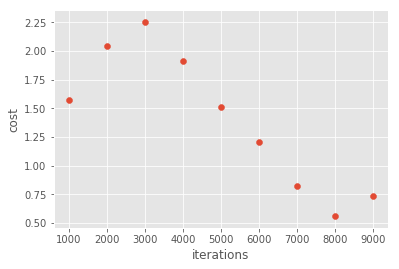

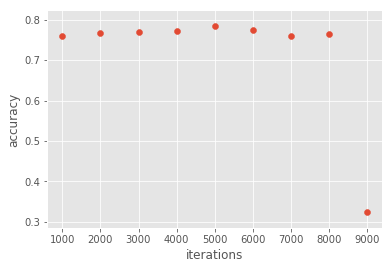

Testing Accuracy: 0.319
Testing cost: 0.74913


In [108]:
"""
Simple demo of a scatter plot.
"""
import numpy as np
import matplotlib.pyplot as plt


#     accs=[]
    
x = iters
y = costs
z = accs

plt.scatter(x, y )
plt.xlabel('iterations')
plt.ylabel('cost')
plt.show()

plt.scatter(x, z)
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()

print ("Testing Accuracy:",test_acc)
print("Testing cost:",test_cost)    


### Scratch below

In [177]:
batch_x, batch_y = PaddedDataIterator(train_df).next_batch(batch_size,100)

In [159]:
batch_x

array([[   5,  176,   34,   33,   55,  473,    5,  371,   68,  111,    4,
        2523,  133,    5,   34,  371,    3,  140,  539,    2,   55,    1,
        2409,   22,    1,   64,  210,   20,  237,    5,  175,  335,   21,
           5,  193,  271,    5, 1097,  326,   53,    1,  216,   57,    9,
        1349,    1,   17,   10,  150,   15,  266,    4,  213,   31, 2480,
           9,  849,    1,   17,   15, 2183, 1508,  426,   11,   15,  352,
          13, 2397,  432,    4,    3,  179, 1624,   40,    0, 2087,  663,
           4,  891,  819,    2,  215,  192,   11,  512,    0,  266,  822,
           7,    3,   62,  207,   23,    1,   43,    2,  612,    5,  125,
          23],
       [   1,  182,   10,   91,    3,   62,  100,    3,  160,  329,  136,
          12,    1,   78,  451,   13,    5,    1,  263,    2,  968,    5,
           1,  124,    5,   16, 1273,    4, 1381,   36,   43,  131, 2129,
        1394,    0, 1723,    4,   17,  101,  692,    0, 1882,   11,    0,
        1361, 2415, 206

In [163]:
batch_x, batch_y = PaddedDataIterator(train_df).next_batch(batch_size,100)
batch_x = batch_x.reshape((batch_size, n_steps, n_input))

x = tf.unstack(x, n_steps, 1)

In [161]:
tf.unstack(x, n_steps, 1)

[<tf.Tensor 'unstack_5:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:1' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:2' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:3' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:4' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:5' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:6' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:7' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:8' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'unstack_5:9' shape=(?, 10) dtype=float32>]

In [156]:
from tensorflow.contrib import rnn

In [ ]:
##define variables 
n_hidden = 10 
with tf.variable_scope("softmax"):
    W_out_ = tf.Variable(tf.random_uniform([n_hidden,1], 0.0, 1.0), name="W_out_")
    b_out_ = tf.Variable(tf.zeros([1], dtype=tf.float32) ,name="b_out_")

with tf.variable_scope("recurrent"):
    rnn_cell = rnn.BasicLSTMCell(n_hidden)
    outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)
    initial_h_ = self.cell_.zero_state(self.batch_size_,dtype=tf.float32)
    outputs, self.final_h_ = tf.nn.dynamic_rnn(self.cell_, inputs=self.x_,initial_state=self.initial_h_, sequence_length=100)



In [196]:
def MakeFancyRNNCell(H, keep_prob, num_layers=1):
    """Make a fancy RNN cell.

    Use tf.nn.rnn_cell functions to construct an LSTM cell.
    Initialize forget_bias=0.0 for better training.

    Args:
      H: hidden state size
      keep_prob: dropout keep prob (same for input and output)
      num_layers: number of cell layers

    Returns:
      (tf.nn.rnn_cell.RNNCell) multi-layer LSTM cell with dropout
    """
    cells = []
    for _ in xrange(num_layers):
        cell = tf.contrib.rnn.BasicLSTMCell(H, forget_bias=0.0)
        cell = tf.contrib.rnn.DropoutWrapper(
        cell, input_keep_prob=keep_prob, output_keep_prob=keep_prob)
        cells.append(cell)
    return tf.contrib.rnn.MultiRNNCell(cells)


In [36]:
##have to fix here!!!
def RNN(x):
    n_hidden = 10 
    with tf.variable_scope("softmax"):
        W_out_ = tf.Variable(tf.random_uniform([n_hidden,1], 0.0, 1.0), name="W_out_")
        b_out_ = tf.Variable(tf.zeros([1], dtype=tf.float32) ,name="b_out_")
    # reshape to [1, n_input]
    n_input = len(x)
    x = tf.reshape(x, [-1, n_input])

    # Generate a n_input-element sequence of inputs
    # (eg. [had] [a] [general] -> [20] [6] [33])
    x = tf.split(x,n_input,1)
#     print x
    # 1-layer LSTM with n_hidden units.
#     with tf.variable_scope('cell_def'):
#         lstm_cell = MakeFancyRNNCell(H=n_hidden,keep_prob=1)
    lstm_cell = tf.contrib.rnn.core_rnn_cell.BasicLSTMCell(n_hidden, forget_bias=0.0)
#     print x
    # generate prediction

    
#     with tf.variable_scope('rnn_def',reuse=True):
    initial_h_ = lstm_cell.zero_state(1,dtype=tf.int32)
    outputs,final_h_ = tf.contrib.rnn.static_rnn(lstm_cell, x,dtype=tf.int32)
            
            

    # there are n_input outputs but
    # we only want the last output
    return tf.matmul(outputs[-1], W_out_) + b_out_

In [37]:
import tensorflow as tf
from tensorflow.contrib import rnn


learning_rate =0.1
pred = RNN(X_sample_ids[0])

# Loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_sample[0]))
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

AttributeError: 'module' object has no attribute 'static_rnn'

In [ ]:
_, loss, onehot_pred = session.run([optimizer, cost, pred], 
                                        feed_dict={x: symbols_in_keys, y: symbols_out_onehot})

### Scratch below

In [17]:
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(60843,)
(26177,)
(60843, 1)
(26177, 1)


In [18]:
X_sample = nonnan_doc_clean[0:100]
y_sample = y[0:100]

In [19]:
print len(X_sample[0].split())
print X_sample[0]
print y[0]

35
This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++
[ 0.875]


In [22]:
len(nltk.corpus.__getattr__('brown').words())

1161192

In [86]:
corpus = X_sample[0].split()
bi = utils.batch_generator(np.array(X_sample[0].split()), batch_size=1, max_time=100)

In [87]:
for i, (w,y) in enumerate(bi):
    print w
    print y_sample[0]

[['For' 'what' 'I' 'paid' 'for' 'two' 'tutus' 'is' 'unbeatable' 'anywhere!'
  'I' 'ordered' 'a' 'pink' 'and' 'turquios' 'and' 'they' 'are' 'vibrant'
  'and' 'beautiful!' 'The' 'tutu' 'is' 'very' 'full!' 'Princess' 'style!'
  'Not' 'cheaply' 'made!' 'Not' 'cheap' 'materia!' 'Obviously' 'someone'
  'made' 'these' 'with' 'love' 'and' 'care!' 'I' 'paid' 'less' 'than' '7'
  'bucks' 'for' 'a' 'tutu' 'I' 'and' 'I' 'feel' 'proud' 'of' 'my' 'self'
  'for' 'researching' 'to' 'the' 'point' 'of' 'finding' 'gold!Recommend'
  '2-6' 'years!My' 'daughter' 'is' 'two' '!' 'Wears' 'size' '4t' 'and'
  'this' 'skirt' '(' 'one' 'size' ')' 'fit' 'perfect' 'and' 'will'
  'probaly' 'be' 'able' 'to' 'accommodate' 'her' 'quickly' 'growing'
  'waist' 'for' 'some']]
[ 0.875]


In [99]:
import rnnlm
# import rnnlm_test
reload(rnnlm)
# reload(rnnlm_test)

<module 'rnnlm' from 'rnnlm.py'>

In [92]:
def run_epoch(lm, session, batch_iterator,
              train=False, verbose=False,
              tick_s=10, learning_rate=0.1):
    start_time = time.time()
    tick_time = start_time  # for showing status
    total_cost = 0.0  # total cost, summed over all words
    total_batches = 0
    total_words = 0

    if train:
        train_op = lm.train_step_
        use_dropout = True
        loss = lm.train_loss_
    else:
        train_op = tf.no_op()
        use_dropout = False  # no dropout at test time
        loss = lm.loss_  # true loss, if train_loss is an approximation

    for i, (w, y) in enumerate(batch_iterator):
        cost = 0.0
        # At first batch in epoch, get a clean intitial state.
        if i == 0:
            h = session.run(lm.initial_h_, {lm.input_w_: w})

        #### YOUR CODE HERE ####
        
        feed_dict = {lm.input_w_:w,
                 lm.target_y_:y,
                 lm.learning_rate_:learning_rate,
                 lm.initial_h_ : h}
            
        cost, _, h = session.run([loss, train_op,lm.final_h_],
                       feed_dict=feed_dict)
        
        
            
            
        #### END(YOUR CODE) ####
        total_cost += cost
        total_batches = i + 1
        total_words += w.size  # w.size = batch_size * max_time

        ##
        # Print average loss-so-far for epoch
        # If using train_loss_, this may be an underestimate.
        if verbose and (time.time() - tick_time >= tick_s):
            avg_cost = total_cost / total_batches
            avg_wps = total_words / (time.time() - start_time)
            print "[batch %d]: seen %d words at %d wps, loss = %.3f" % (
                i, total_words, avg_wps, avg_cost)
            tick_time = time.time()  # reset time ticker

    return total_cost / total_batches

In [93]:
V=1000
max_time = 20
batch_size = 50
learning_rate = 0.5
num_epochs = 5

# Model parameters
model_params = dict(V=100, 
                    H=100, 
                    softmax_ns=200,
                    num_layers=1)

# TF_SAVEDIR = "tf_saved"
# checkpoint_filename = os.path.join(TF_SAVEDIR, "rnnlm")
# trained_filename = os.path.join(TF_SAVEDIR, "rnnlm_trained")

In [101]:
# Will print status every this many seconds
import rnnlm
# import rnnlm_test
reload(rnnlm)
print_interval = 5

# Clear old log directory
shutil.rmtree("tf_summaries", ignore_errors=True)

lm = rnnlm.RNNLM(**model_params)
lm.BuildCoreGraph()
lm.BuildTrainGraph()

# Explicitly add global initializer and variable saver to LM graph
with lm.graph.as_default():
    initializer = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
# Clear old log directory
# shutil.rmtree(TF_SAVEDIR, ignore_errors=True)
# if not os.path.isdir(TF_SAVEDIR):
#     os.makedirs(TF_SAVEDIR)

with tf.Session(graph=lm.graph) as session:
    # Seed RNG for repeatability
    tf.set_random_seed(42)

    session.run(initializer)

    for epoch in xrange(1,num_epochs+1):
        t0_epoch = time.time()
#         bi = utils.batch_generator(train_ids, batch_size, max_time)
        corpus = X_sample[0].split()
        bi = utils.batch_generator(np.array(X_sample[0].split()), batch_size=1, max_time=100)
        for i, (w,y) in enumerate(bi):
            w1=w
            
        bi= (w1,y_sample[y])
        print "[epoch %d] Starting epoch %d" % (epoch, epoch)
        #### YOUR CODE HERE ####
        # Run a training epoch.
        cost = run_epoch(lm, session, bi, 
                     learning_rate=learning_rate, train=True, 
                     verbose=False, tick_s=3600)

        #### END(YOUR CODE) ####
        print "[epoch %d] Completed in %s" % (epoch, utils.pretty_timedelta(since=t0_epoch))
    
        # Save a checkpoint
        saver.save(session, checkpoint_filename, global_step=epoch)
    
        ##
        # score_dataset will run a forward pass over the entire dataset
        # and report perplexity scores. This can be slow (around 1/2 to 
        # 1/4 as long as a full epoch), so you may want to comment it out
        # to speed up training on a slow machine. Be sure to run it at the 
        # end to evaluate your score.
        print ("[epoch %d]" % epoch),
        #score_dataset(lm, session, train_ids, name="Train set")
        print ("[epoch %d]" % epoch),
        score_dataset(lm, session, test_ids, name="Test set")
        print ""
    
    # Save final model
    saver.save(session, trained_filename)

ValueError: Dimension must be 2 but is 3 for 'recurrent/transpose' (op: 'Transpose') with input shapes: [?,100], [3].

## Scratch Below

In [ ]:
print 1

In [62]:
import nltk
nltk.download('brown')

corpus = nltk.corpus.brown

[nltk_data] Downloading package brown to /Users/legu/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [72]:
!pip install vocabulary

    100% |████████████████████████████████| 593kB 408kB/s 
    100% |████████████████████████████████| 61kB 1.9MB/s 
    100% |████████████████████████████████| 102kB 1.2MB/s 
  Running setup.py bdist_wheel for vocabulary ... - \ done
  Stored in directory: /Users/legu/Library/Caches/pip/wheels/36/6c/c0/92bb20f79402d055c3bce3e89d9f2cce5d6937bc2aadc0fb45
Successfully built vocabulary
  Found existing installation: requests 2.11.1
    Uninstalling requests-2.11.1:
      Successfully uninstalled requests-2.11.1
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [73]:
import utils
import vocabulary
# train_sents, test_sents = utils.get_train_test_sents(corpus, split=0.8, shuffle=True)
vocab = vocabulary.Vocabulary(utils.canonicalize_word(w) for w in utils.flatten(corpus))
print "Train set vocabulary: %d words" % vocab.size

AttributeError: 'module' object has no attribute 'Vocabulary'